In [242]:
#%matplotlib inline
import matplotlib.pylab as plt

In [243]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from pandas_datareader import data as web
from pykrx import stock
import pandas_datareader as pdr

In [244]:
from scipy.optimize import minimize

In [245]:
# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    
    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, rf):
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        #샤프비율을 효용함수로 한다
        util = (mean - rf) / np.sqrt(var) 
        # 효용함수 극대화= 효용함수 역함수를 최소화하는 것이다.
        return 1 / util  

    n = len(R)  # 투자자산 갯수

    # 동일비중으로 최적화 시작
    W = np.ones([n]) / n  
    # 비중범위는 0~100%사이(공매도나 차입조건이 없음)
    bnds = [(0., 1.) for i in range(n)]  
    # 제약조건은 비중합=100%
    cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) 
    # 최적화
    res = minimize(obj, W, (R, C, rf), method='SLSQP', constraints=cons, bounds=bnds)
    if not res.success:
      # 최적화 실패한 경우 
      raise BaseException(res.message)
    # 최적화 결과를 돌려준다  
    return res.x

In [246]:
# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수

    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 

        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        if not res.success:
            # 최적화에 실패한 경우
            raise BaseException(res.message)
        
        # 효율적 프런티어 평균과 분산리스트에 
        # 최적포트폴리오 수익률과 분산 추가
        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var)

In [247]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):

    # 접점포트폴리오 계산
    W = solveWeights(R, C, rf)
    # 투자비중으로 계산한 평균과 분산
    tan_mean = sum(R * W)
    tan_var = np.dot(np.dot(W, C), W)    

    # 효율적 포트폴리오 계산
    eff_mean, eff_var = solveFrontier(R, C, rf)

    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights':W, 'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var}

In [248]:
# 자산에 대한 투자자의 전망과 전망의 기대수익률을 행렬로 만든다
def CreateMatrixPQ(names, views):
    r, c = len(views), len(names)

    # 투자전망과 기대수익률 행렬
    # views[i][3]에는 기대수익률을 가리킴
    Q = [views[i][3] for i in range(r)]     

    # 전망행렬 P를 만들기 위해
    # 구성자산 딕셔너리 작성
    nameToIndex = dict()    
    for i, n in enumerate(names):
        nameToIndex[n] = i

    # 투자전망 
    P = np.zeros([r, c]) 
    for i, v in enumerate(views):
        # 가령 전망이 ('MSFT', '>', 'GE', 0.02) 이라면
        # views[i][0] <-- 'MSFT' --> name1
        # views[i][1] <-- '>'
        # views[i][2] <-- 'GE'   --> name2
        # views[i][3] <-- '0.02'
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P

데이터 읽기

In [249]:
cap = stock.get_market_cap('20220515')['시가총액']
cap = cap.to_dict()
cap

{'005930': 395796583065000,
 '373220': 93717000000000,
 '000660': 80444261332500,
 '207940': 54803980000000,
 '005935': 48385737960000,
 '035420': 44867424747500,
 '006400': 40364779110000,
 '005380': 39314946408000,
 '035720': 36548454086600,
 '051910': 35790317901000,
 '000270': 34536957164400,
 '005490': 24499500635000,
 '105560': 24205091397800,
 '055550': 21722760447850,
 '028260': 21678901396000,
 '068270': 19837009410000,
 '096770': 18955440620000,
 '012330': 18867332253000,
 '323410': 18500231577450,
 '034730': 18203660269500,
 '066570': 17592140005000,
 '011200': 14768992779200,
 '015760': 14540486344050,
 '086790': 13744716460200,
 '032830': 13040000000000,
 '017670': 12933038810400,
 '034020': 12673046346850,
 '010950': 12327815724000,
 '259960': 11826362845000,
 '009150': 11801603968000,
 '003550': 11703193879200,
 '033780': 11463923499500,
 '316140': 11430550619300,
 '377300': 11366889791400,
 '329180': 11274185732000,
 '018260': 11142403200000,
 '051900': 10807792324000,


In [250]:
v_b = ["005380","017670","003550","029780","000120"]
# 대형가치  현대차,SK텔레콤, LG, 삼성카드, CJ대한통운

v_m = ['042700', '181710', '214320', '003530', '001530', '034310', '001880',
 '003070', '007690', '008490', '001790', '016800', '009410', '000480',
 '004700', '001940', '036530', '002810', '015360', '001750', '100840', '034590', '004450', '008110']
# 중소형가치   한미반도체, NHN, 이노션, 한화투자증권, DI동일, NICE, DL건설, 코오롱글로벌, 국도화학, 서흥, 
# 대한제당, 퍼시스, 태영건설, 조선내화, 조광피혁, KISCO홀딩스, SNT홀딩스, 삼영무역, 예스코홀딩스, 한양증권, 
# SNT에너지, 인천도시가스, 삼화왕관, 대동전자


g_b = ["000660","035420","006400","000270","011790","000100","138040","020150","000990","000080"]
# 대형성장   SK하이닉스,NAVER,삼성SDI,기아,SKC,유한양행,메리츠금융지주,일진머티리얼즈,DB하이텍,하이트진로

g_m = ['093370', '195870', '016710', '017390', '034120', '002840', '017960', '001720', '009160', '092220', 
'117580', '075580', '018470',
 '024090', '002460', '002710', '011500', '023450', '004080', '006880',
 '009180', '003720', '003780', '024900', '006200']
# 중소형성장    후성, 해성디에스, 대성홀딩스, 서울가스, SBS, 미원상사, 한국카본, 신영증권, SIMPAC, KEC,
    # 대성에너지, 세진중공업, 조일알미늄, 디씨엠, 화성산업, TCC스틸, 한농화성, 동남합성, 신흥, 신송홀딩스, 
    # 한솔로지스틱스, 삼영화학, 진양산업, 덕양산업, 한국전자홀딩스

all = ["005380","017670","003550","029780","000120",'042700', '181710', '214320', '003530', '001530', '034310', '001880',
 '003070', '007690', '008490', '001790', '016800', '009410', '000480',
 '004700', '001940', '036530', '002810', '015360', '001750', '100840', '034590', '004450', '008110',
 "000660","035420","006400","000270","011790","000100","138040","020150","000990","000080",'093370', '195870', '016710', '017390', '034120', '002840', '017960', '001720', '009160', '092220', 
'117580', '075580', '018470',
 '024090', '002460', '002710', '011500', '023450', '004080', '006880',
 '009180', '003720', '003780', '024900', '006200']

In [251]:
tickers = all

In [252]:
import datetime as dt
start = dt.datetime(2017,1,1)
end = dt.datetime(2022,5,15)
prices, caps = [], []
# try:
#     pxclose = web.DataReader(tickers+'.ks','yahoo',start, end)
#     prices.append(list(pxclose))
#     caps.append(cap=[tickers])
# except:
#     "결측치"
for s in tickers:
    pxclose = pdr.DataReader(s+'.ks','yahoo',start, end)['Adj Close']
    # pxclose = fdr.DataReader(s, '2017-01-01', "2022-05-15")['Close']
    prices.append(list(pxclose))
    caps.append(cap[s])

In [253]:
pxclose

Date
2020-01-02     726
2020-01-03     733
2020-01-06     722
2020-01-07     721
2020-01-08     714
2020-01-09     724
2020-01-10     723
2020-01-13     727
2020-01-14     733
2020-01-15     725
2020-01-16     725
2020-01-17     721
2020-01-20     721
2020-01-21     722
2020-01-22     721
2020-01-23     722
2020-01-28     717
2020-01-29     720
2020-01-30     710
2020-01-31     708
2020-02-03     703
2020-02-04     709
2020-02-05     710
2020-02-06     713
2020-02-07     715
2020-02-10     710
2020-02-11     717
2020-02-12     713
2020-02-13     709
2020-02-14     710
2020-02-17     705
2020-02-18     708
2020-02-19     703
2020-02-20     693
2020-02-21     703
2020-02-24     691
2020-02-25     701
2020-02-26     698
2020-02-27     690
2020-02-28     680
2020-03-02     680
2020-03-03     668
2020-03-04     671
2020-03-05     665
2020-03-06     660
2020-03-09     660
2020-03-10     620
2020-03-11     600
2020-03-12     600
2020-03-13     469
2020-03-16     467
2020-03-17     485
2020-03

In [254]:
prices

[[113488.375,
  111564.8359375,
  111564.8359375,
  111083.9609375,
  107717.7734375,
  107236.890625,
  109160.421875,
  110603.0703125,
  111564.8359375,
  110603.0703125,
  113969.25,
  113969.25,
  113488.375,
  112526.6015625,
  122144.265625,
  125510.4453125,
  125991.328125,
  125991.328125,
  122625.140625,
  120220.7265625,
  118778.078125,
  119258.9609375,
  119258.9609375,
  126953.0859375,
  125991.328125,
  125029.5546875,
  127433.96875,
  130800.1484375,
  127914.8671875,
  128395.7421875,
  130319.2734375,
  127433.96875,
  126472.203125,
  125029.5546875,
  123106.03125,
  117816.3203125,
  117816.3203125,
  117816.3203125,
  116373.6640625,
  110603.0703125,
  109160.421875,
  108198.65625,
  108679.5390625,
  109641.3046875,
  106275.125,
  106275.125,
  98100.1171875,
  96176.578125,
  96176.578125,
  83865.984375,
  79730.390625,
  77037.4453125,
  70689.7890625,
  63380.3671875,
  68381.546875,
  66265.6640625,
  71940.0859375,
  81269.2109375,
  81653.9140625,


In [255]:
caps

[39314946408000,
 12933038810400,
 11703193879200,
 3846515181200,
 2999823236000,
 1414552482200,
 1131165137250,
 1016000000000,
 890373266250,
 632814682500,
 619375605000,
 535894801200,
 497906150500,
 475760524800,
 425743358400,
 439064759100,
 391000000000,
 340367107500,
 325600000000,
 307522632500,
 279851374000,
 277981256300,
 249303798000,
 213300000000,
 164834515300,
 144879522300,
 120305735000,
 95223551800,
 78573448030,
 80444261332500,
 44867424747500,
 40364779110000,
 34536957164400,
 5358364167000,
 4232779312800,
 3931538820000,
 3758033052500,
 3165619324400,
 2514289954350,
 1889179107600,
 1147500000000,
 963758594100,
 945000000000,
 938182714800,
 829990000000,
 562697689600,
 535015509000,
 523436128000,
 465365273315,
 390500000000,
 370658453120,
 314331619710,
 320340000000,
 291348720000,
 273775000000,
 245501559400,
 210102000000,
 160075000000,
 133666095400,
 111695732625,
 106930000000,
 105430000000,
 106324659700,
 81905488000]

최적화에 사용할 필요한 값을 미리 계산

In [256]:
n = len(tickers)
W = np.array(caps) / sum(caps) # 시가총액의 비율계산

prices = np.matrix(prices)  # prices를 numpy matrix로 변환

# 수익률 행렬을 만들어 계산
rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률계산
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

# 공분산계산
covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화
C = covars * 250  # 연율화

# 무위험 이자율
rf = .020 #.015

In [257]:
expreturns

array([ 1.18893751e-03,  1.53080362e-04,  3.95757565e-04,  1.76927935e-04,
       -6.71010425e-05,  2.80428112e-03,  1.57041497e-04, -2.06845180e-04,
        2.00572626e-03,  2.80272958e-03, -1.49716905e-04,  6.62861124e-04,
        1.91851371e-03,  9.61970719e-04,  2.26368339e-04,  1.96346640e-03,
        5.05888117e-04, -4.91378730e-04, -9.23128536e-05,  6.74005813e-04,
        6.79645713e-04,  3.24412161e-04, -2.24364246e-04,  1.22342149e-05,
        1.10368286e-03,  3.01519763e-04, -2.76201259e-05,  7.25252844e-05,
        1.87154237e-03,  5.85106967e-04,  9.58389836e-04,  1.99672827e-03,
        1.58568784e-03,  2.33384176e-03,  7.72067057e-04,  2.07964462e-03,
        1.56099376e-03,  2.07321085e-03,  6.07217485e-04,  2.06902009e-03,
        3.00045958e-03,  3.51661966e-03,  1.93991166e-03,  2.00932964e-03,
        1.90587211e-03,  1.30413060e-03,  1.41647365e-04,  2.24775761e-03,
        3.03919800e-03,  2.62813004e-03,  2.20142347e-03,  2.97726092e-03,
        1.72759647e-03,  

In [258]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=tickers).T)

,005380,017670,003550,029780,000120,042700,181710,214320,003530,001530,...,002710,011500,023450,004080,006880,009180,003720,003780,024900,006200
Return,34.59%,3.90%,10.40%,4.52%,-1.66%,101.39%,4.00%,-5.04%,65.03%,101.32%,...,150.43%,124.01%,50.41%,35.35%,70.71%,90.01%,87.55%,61.83%,80.72%,92.54%
Weight (based on market cap),12.40%,4.08%,3.69%,1.21%,0.95%,0.45%,0.36%,0.32%,0.28%,0.20%,...,0.09%,0.08%,0.07%,0.05%,0.04%,0.04%,0.03%,0.03%,0.03%,0.03%


In [259]:
display(pd.DataFrame(C, columns=tickers, index=tickers))
corr = pd.DataFrame(C, columns=tickers, index=tickers)

,005380,017670,003550,029780,000120,042700,181710,214320,003530,001530,...,002710,011500,023450,004080,006880,009180,003720,003780,024900,006200
005380,17.13%,3.62%,7.11%,5.13%,2.99%,7.39%,3.58%,7.52%,10.09%,6.82%,...,8.43%,7.00%,1.02%,1.18%,3.61%,7.67%,6.07%,6.15%,8.54%,7.36%
017670,3.62%,15.79%,4.32%,3.15%,2.49%,3.20%,2.16%,3.11%,5.25%,4.35%,...,5.53%,3.21%,1.76%,1.05%,1.95%,4.91%,4.77%,3.93%,4.85%,4.10%
003550,7.11%,4.32%,17.66%,3.94%,3.11%,4.85%,3.26%,6.06%,7.10%,7.96%,...,8.24%,6.37%,1.42%,1.16%,1.86%,4.86%,5.66%,4.94%,5.95%,5.45%
029780,5.13%,3.15%,3.94%,8.56%,2.44%,5.26%,3.04%,4.47%,7.81%,4.79%,...,5.78%,4.14%,1.16%,1.66%,2.89%,5.10%,3.26%,5.05%,3.59%,4.27%
000120,2.99%,2.49%,3.11%,2.44%,9.75%,2.61%,2.61%,2.42%,3.81%,3.27%,...,3.42%,3.43%,1.04%,0.40%,0.77%,5.28%,3.22%,4.58%,3.15%,4.40%
042700,7.39%,3.20%,4.85%,5.26%,2.61%,28.27%,6.38%,5.43%,12.32%,9.13%,...,9.06%,7.79%,1.62%,3.20%,3.89%,8.23%,7.78%,10.33%,8.21%,11.58%
181710,3.58%,2.16%,3.26%,3.04%,2.61%,6.38%,16.16%,3.52%,7.44%,4.64%,...,5.27%,4.05%,1.11%,0.99%,2.08%,7.68%,5.41%,6.46%,4.34%,4.01%
214320,7.52%,3.11%,6.06%,4.47%,2.42%,5.43%,3.52%,11.43%,7.47%,5.76%,...,5.20%,3.96%,1.78%,0.46%,2.12%,5.78%,4.99%,4.43%,6.41%,6.20%
003530,10.09%,5.25%,7.10%,7.81%,3.81%,12.32%,7.44%,7.47%,40.83%,8.50%,...,10.80%,6.83%,1.48%,2.26%,6.16%,10.85%,6.89%,8.71%,8.74%,9.40%
001530,6.82%,4.35%,7.96%,4.79%,3.27%,9.13%,4.64%,5.76%,8.50%,31.07%,...,15.71%,9.76%,1.67%,2.12%,4.62%,9.10%,7.82%,6.83%,8.39%,9.47%


<AxesSubplot:>

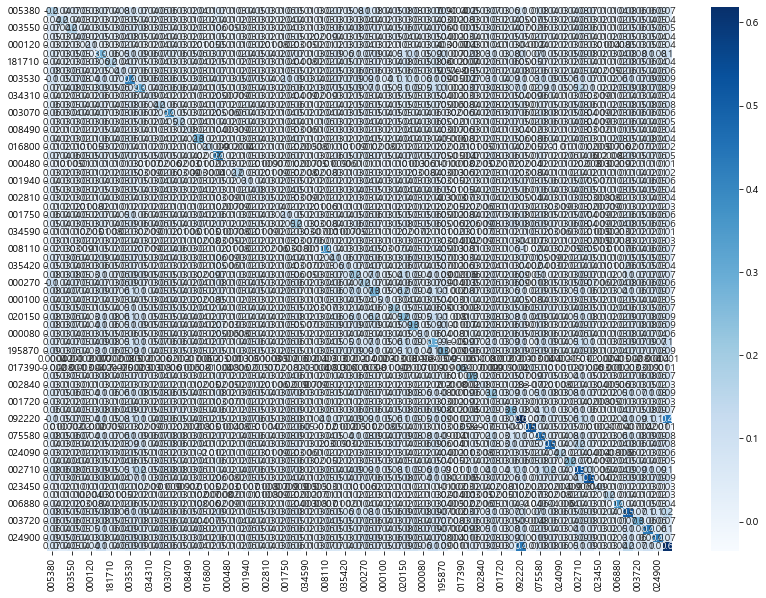

In [260]:
import seaborn as sns
sns.heatmap(corr,annot=True,fmt='.1g',cmap='Blues') 

과거 데이터를 이용한 최적화

In [261]:
opt1 = optimize_frontier(R, C, rf)  

블랙-리터만 역최적화

In [262]:
# 포트폴리오 수익률 평균 및 분산
mean = sum(R * W)
var = np.dot(np.dot(W, C), W)

# 위험회피계수
lmbda = (mean - rf) / var  

# 균형초과수익률
pi = np.dot(np.dot(lmbda, C), W) 

균형기대수익률로 최적화

In [263]:
opt2 = optimize_frontier(pi+rf, C, rf)

투자자 전망과 기대수익률 그리고 전망의 불확실성 계산

In [264]:
# views = [("029780", '<', "005380", 0.01)] 
# 현대차,SK텔레콤,LG, 삼성카드,CJ대한통운
#v_b

# views = [("042700", '<', "001530", 0.020),("001940", '<', "008490", 0.02),
# ("042700", '<', "008490", 0.01),("042700", '<', "003070", 0.015),("001940", '<', "001530", 0.02)] # 중소형가치
#v_m

# views = [("000080", '<', "006400", 0.05),("000080", '<', "000990", 0.03),("000080", '<', "035420", 0.02),("000080", '<', "020150", 0.01), 
# ("011790", '<', "006400", 0.025),("011790", '<', "000990", 0.02),("011790", '<', "035420", 0.01)]# 대형성장
#g_b


# views = [("017960", '<', "093370", 0.02),("009160",'<',"093370",0.02),
# ("009160",'<',"002710",0.03),("017960",'<',"002710",0.025)] 
# 중소형성장 
#g_m


views = [("029780", '<', "005380", 0.01), 
("042700", '<', "001530", 0.02),("001940", '<', "008490", 0.02),("042700", '<', "008490", 0.01),("042700", '<', "003070", 0.015),("001940", '<', "001530", 0.02), 
("000080", '<', "006400", 0.05),("000080", '<', "000990", 0.03),("000080", '<', "035420", 0.02),("011790", '<', "006400", 0.025),("011790", '<', "000990", 0.02), 
("017960", '<', "093370", 0.02),("009160",'<',"093370",0.02),("009160",'<',"002710",0.03),("017960",'<',"002710",0.025)]
# all

Q, P = CreateMatrixPQ(tickers, views)

# 위험조정상수   우리는 자산의 60%가 투자니까 (1-0.6)/0.6
tau = .066  

# 투자자 전망의 불확실성 계산
# tau * P * C * transpose(P)
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  

In [265]:
print(Q,P)

[0.01  0.02  0.02  0.01  0.015 0.02  0.05  0.03  0.02  0.025 0.02  0.02
 0.02  0.03  0.025] [[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  

블랙-리터만 모델 최적화

In [266]:
# 투자자 전망과 합쳐진 균형초과수익률 계산
bl1 = inv(np.dot(tau, C))
bl2 = np.dot(np.dot(np.transpose(P), inv(omega)), P)
bl3 = np.dot(inv(np.dot(tau, C)), pi)
bl4 = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
pi_adj = np.dot(inv(bl1 + bl2), (bl3 + bl4))

opt3 = optimize_frontier(pi_adj + rf, C, rf)

BaseException: Inequality constraints incompatible

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
from IPython.core.display import display, HTML
pd.options.display.float_format = '{:.2%}'.format

# 1번째 최적화 결과
display(HTML('<h2>Historical returns</h2>'))
display(pd.DataFrame({'Weight': opt1['weights']}, index=tickers).T)

# 2번째 최적화 결과
display(HTML('<h2>Implied returns</h2>'))
display(pd.DataFrame({'Weight': opt2['weights']}, index=tickers).T)

# 3번째 최적화 결과
display(HTML('<h2>Implied returns with adjusted views</h2>'))
display(pd.DataFrame({'Weight': opt3['weights']}, index=tickers).T)

C:\Users\TAEYONG\AppData\Local\Temp\ipykernel_21356\762100858.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,005380,017670,003550,029780,000120,042700,181710,214320,003530,001530,...,002710,011500,023450,004080,006880,009180,003720,003780,024900,006200
Weight,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,1.10%,3.97%,0.91%,0.00%,0.89%,0.00%,0.00%


,005380,017670,003550,029780,000120,042700,181710,214320,003530,001530,...,002710,011500,023450,004080,006880,009180,003720,003780,024900,006200
Weight,12.28%,4.03%,3.66%,1.28%,0.94%,0.42%,0.35%,0.35%,0.28%,0.20%,...,0.08%,0.09%,0.09%,0.08%,0.05%,0.04%,0.03%,0.03%,0.04%,0.03%


,005380,017670,003550,029780,000120,042700,181710,214320,003530,001530,...,002710,011500,023450,004080,006880,009180,003720,003780,024900,006200
Weight,0.00%,1.42%,0.00%,0.00%,0.00%,10.93%,0.00%,0.00%,1.22%,6.82%,...,0.00%,0.00%,2.66%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


In [ ]:
def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color)  
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력
    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'tangent', verticalalignment='center', color=color)
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], marker='o', color=color)
    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=9) 

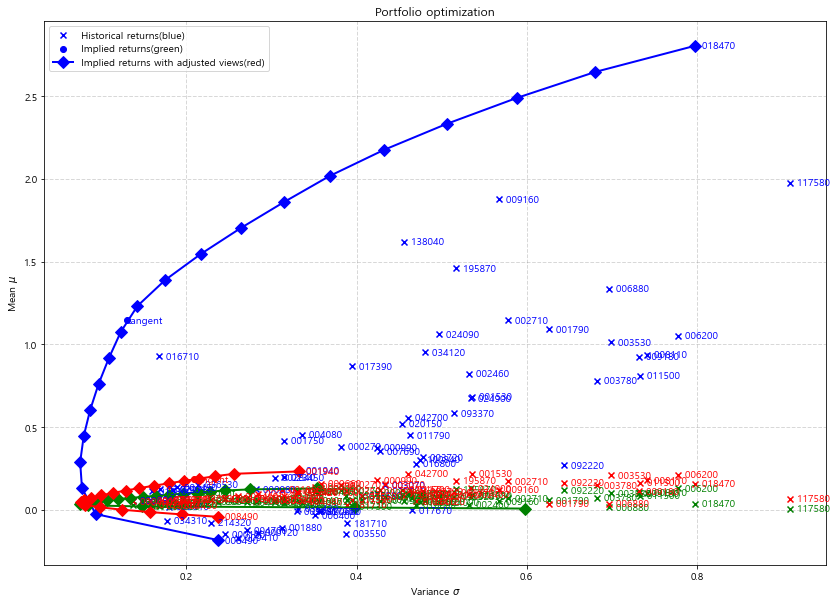

In [ ]:
# 1번째 최적화 결과를 차트로 출력
plotAssets(tickers, R, C, color='blue')
plotFrontier(opt1, label='Historical returns', color='blue')

# 2번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi+rf, C, color='green')
plotFrontier(opt2, label='Implied returns', color='green')

# 3번째 최적화 결과를 차트로 출력
plotAssets(tickers, pi_adj+rf, C, color='red')
plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

# 차트에 공통된 속성을 지정한다(차트크기, 제목, 범례, 축이름 등)
plt.rcParams["figure.figsize"] = (14, 10) #12,10
plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
plt.title('Portfolio optimization')
plt.legend(['Historical returns(blue)', 'Implied returns(green)','Implied returns with adjusted views(red)'])
plt.xlabel('Variance $\sigma$')
plt.ylabel('Mean $\mu$')
plt.show()

In [ ]:
pd.DataFrame({'tan_mean':[opt1['tan_mean'],opt2['tan_mean'],opt3['tan_mean']], 
            'tan_var':[opt1['tan_var'],opt2['tan_var'],opt3['tan_var']]}, 
            index=['opt1','opt2','opt3'])

,tan_mean,tan_var
opt1,114.64%,1.71%
opt2,10.59%,4.73%
opt3,18.39%,4.37%


In [ ]:
high = (((opt3['tan_mean']+1)*0.8+(0.2*1.024))-1)
mid = ((opt3['tan_mean']+1)*0.6+(0.4*1.024))-1
low = ((opt3['tan_mean']+1)*0.5+(0.5*1.024))-1

In [ ]:
# high = (((0.3444+1)*0.8+(0.2*1.024))-1)
# mid = ((0.3444+1)*0.6+(0.4*1.024))-1
# low = ((0.3444+1)*0.5+(0.5*1.024))-1

In [ ]:
pd.DataFrame({'적극투자형':high, 
            '위험중립형':mid,'안정추구형':low}, 
            index=['포트폴리오 예상수익률'])

,적극투자형,위험중립형,안정추구형
포트폴리오 예상수익률,15.19%,12.00%,10.40%


In [ ]:
# '현대차','SK텔레콤', 'LG', '삼성카드', 'CJ대한통운',

# '한미반도체', 'NHN', '이노션', '한화투자증권', 'DI동일', 'NICE', 'DL건설', '코오롱글로벌', '국도화학', '서흥', 
# '대한제당', '퍼시스', '태영건설', '조선내화', '조광피혁', 'KISCO홀딩스', 'SNT홀딩스', '삼영무역', '예스코홀딩스', '한양증권', 
# 'SNT에너지', '인천도시가스', '삼화왕관', '대동전자',



#  'SK하이닉스','NAVER','삼성SDI','기아','SKC','유한양행','DB하이텍','하이트진로'

# '후성', '해성디에스', '대성홀딩스', '서울가스', 'SBS', '미원상사', '한국카본', '신영증권', 'SIMPAC', 'KEC',
#     '대성에너지', '세진중공업', '조일알미늄', '디씨엠', '화성산업', 'TCC스틸', '한농화성', '동남합성', '신흥', '신송홀딩스', 
#     '한솔로지스틱스', '삼영화학', '진양산업', '덕양산업', '한국전자홀딩스'

In [ ]:
proportion = pd.DataFrame(np.array([opt1['weights'], 
            opt2['weights'],opt3['weights'],tickers]), 
            index=['opt1','opt2','opt3','종목코드'],columns=[ 
               '현대차','SK텔레콤', 'LG', '삼성카드', 'CJ대한통운',

'한미반도체', 'NHN', '이노션', '한화투자증권', 'DI동일', 'NICE', 'DL건설', '코오롱글로벌', '국도화학', '서흥', 
'대한제당', '퍼시스', '태영건설', '조선내화', '조광피혁', 'KISCO홀딩스', 'SNT홀딩스', '삼영무역', '예스코홀딩스', '한양증권', 
'SNT에너지', '인천도시가스', '삼화왕관', '대동전자',



 'SK하이닉스','NAVER','삼성SDI','기아','SKC','유한양행','메리츠금융지주','일진머티리얼즈','DB하이텍','하이트진로', 
 
 '후성', '해성디에스', '대성홀딩스', '서울가스', 'SBS', '미원상사', '한국카본', '신영증권', 'SIMPAC', 'KEC',
    '대성에너지', '세진중공업', '조일알미늄', '디씨엠', '화성산업', 'TCC스틸', '한농화성', '동남합성', '신흥', '신송홀딩스', 
    '한솔로지스틱스', '삼영화학', '진양산업', '덕양산업', '한국전자홀딩스' 
    ]).T

proportion.apply(pd.to_numeric)
#.to_csv('./1년치 all.csv')

,opt1,opt2,opt3,종목코드
현대차,0.00%,12.28%,0.00%,5380
SK텔레콤,0.00%,4.03%,1.42%,17670
LG,0.00%,3.66%,0.00%,3550
삼성카드,0.00%,1.28%,0.00%,29780
CJ대한통운,0.00%,0.94%,0.00%,120
한미반도체,0.00%,0.42%,10.93%,42700
NHN,0.00%,0.35%,0.00%,181710
이노션,0.00%,0.35%,0.00%,214320
한화투자증권,0.00%,0.28%,1.22%,3530
DI동일,0.00%,0.20%,6.82%,1530
